In [1]:
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


import cv2
import torch
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
PATH = os.getcwd()
PATH

'/home/leeping/Documents/Repositories/ML-CV-Facial-Keypoint-Detection'

## 1. Detect All Faces in Image

Use a pre-trained Haar Cascade frontal face detector to locate the faces in the image.

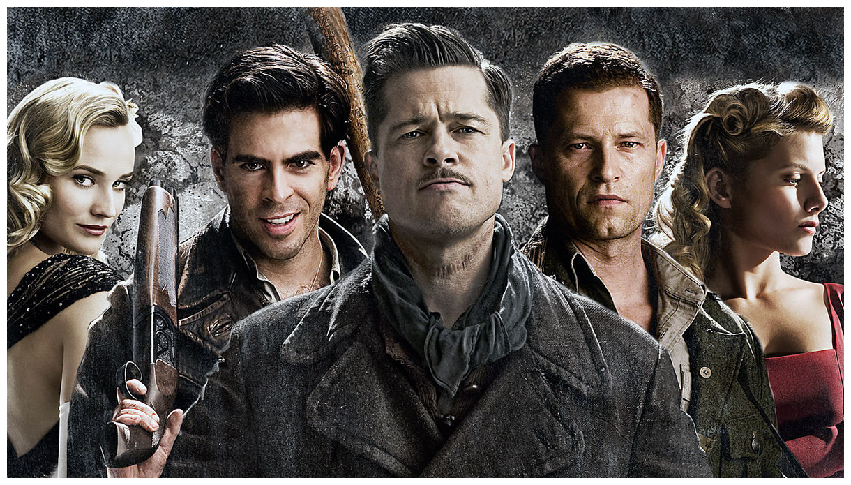

In [4]:
# load in color image for face detection
image = cv2.imread(PATH+'/images/basterds.jpg')

# convert from BGR to RGB (openCV reads in image as BGR)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

fig = plt.figure(figsize=(15, 10))
plt.imshow(image)
plt.axis('off')
plt.show()

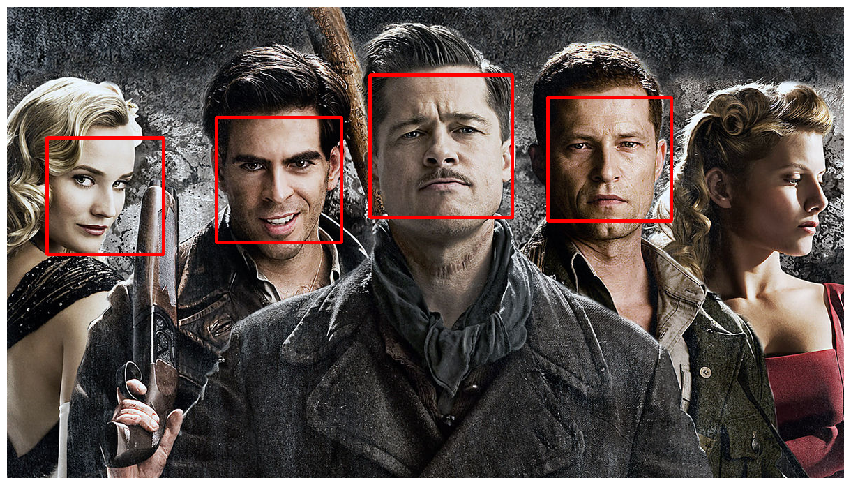

In [19]:
from src.detect_face import detect_face

# if the bounding boxes don't look right, try adjusting the value of scale_factor
face_vertices = detect_face(PATH+'/detector_architectures/haarcascade_frontalface_default.xml',
                   image, fig_width=15, scale_factor=1.2, show=True)

## 2. Train CNN to Recognize Facial Keypoints

In [ ]:
# Download data and extract into path/data

# %%capture

# !wget -P data/ https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
# !unzip -n data/train-test-data.zip -d data

In [36]:
from src.preprocess import prepare_data

train_dataset, test_dataset = prepare_data(path_train_csv = PATH+'/data/training_frames_keypoints.csv',
                                          path_test_csv = PATH+'/data/test_frames_keypoints.csv',
                                          path_train_images = PATH+'/data/training/',
                                           path_test_images = PATH+'/data/test/')

Data preprocessed and transformed.
No. of training data:  3462
No. of test data:  770


In [37]:
# load training data in batches
batch_size = 64
train_loader = DataLoader(train_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=1)

# load test data in batches
batch_size = 64
test_loader = DataLoader(test_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=1)

In [26]:
from src.model import Net
net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(4, 4), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop1): Dropout(p=0.1, inplace=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop2): Dropout(p=0.2, inplace=False)
  (conv3): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop3): Dropout(p=0.3, inplace=False)
  (conv4): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop4): Dropout(p=0.4, inplace=False)
  (fc1): Linear(in_features=43264, out_features=1000, bias=True)
  (drop5): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=1000, out_features=1000, bias=True)
  (drop6): Dropout(p=0.6, inplace=False)
  (fc3): Linear(in_features=10

In [27]:
from src.train import train

n_epochs = 50
use_GPU = True
net, train_loss, valid_loss = train(n_epochs, 
                                   net, 
                                   train_loader, 
                                   test_loader,
                                   use_GPU)

NameError: name 'train_loader' is not defined

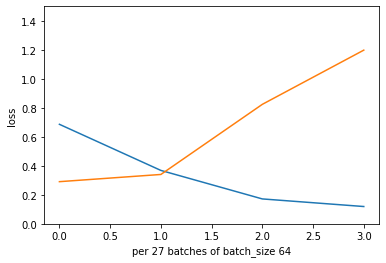

In [48]:
plt.plot(train_loss)
plt.plot(valid_loss)
plt.xlabel('per 27 batches of batch_size 64')
plt.ylabel('loss')
plt.ylim(0, 1.5) # consistent scale
plt.show()

In [60]:
#torch.save(net.state_dict(), PATH + '/saved_models/naimish_net_1epoch.pt')

## 3. Plot Facial Keypoints on Image

In [35]:
net.load_state_dict(torch.load(PATH+'/saved_models/naimish_net_30epochs.pt'))

<All keys matched successfully>

In [36]:
net.eval()

Net(
  (conv1): Conv2d(1, 32, kernel_size=(4, 4), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop1): Dropout(p=0.1, inplace=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop2): Dropout(p=0.2, inplace=False)
  (conv3): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop3): Dropout(p=0.3, inplace=False)
  (conv4): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop4): Dropout(p=0.4, inplace=False)
  (fc1): Linear(in_features=43264, out_features=1000, bias=True)
  (drop5): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=1000, out_features=1000, bias=True)
  (drop6): Dropout(p=0.6, inplace=False)
  (fc3): Linear(in_features=10

## 4. Add Features to Faces

Image shape:  (106, 260, 4)
The alpha channel looks like this (black pixels = transparent): 


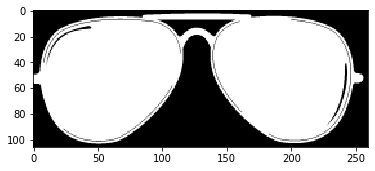

In [57]:
# load in sunglasses image with cv2 and IMREAD_UNCHANGED
shades = cv2.imread('images/shades.png', cv2.IMREAD_UNCHANGED)

# plot our image
plt.imshow(shades)

# print out its dimensions
print('Image shape: ', shades.shape)

alpha_channel = shades[:,:,3]
print ('The alpha channel looks like this (black pixels = transparent): ')
plt.imshow(alpha_channel, cmap='gray')

<img src="images/landmarks_numbered.jpg" width=50% height=50%/>

In [28]:
use_GPU

True

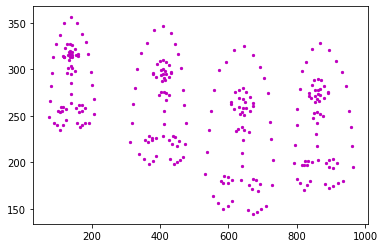

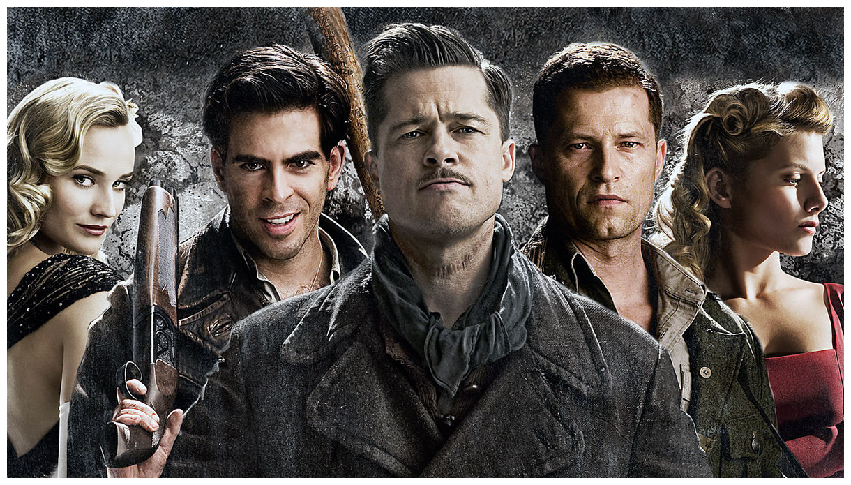

In [38]:
from src.draw import show_keypoints

# need padding as the haar cascade's bounding box is very close to face
# but training images are zoomed out further
show_keypoints(image, face_vertices, net, use_GPU, fig_width=15, pad=50)

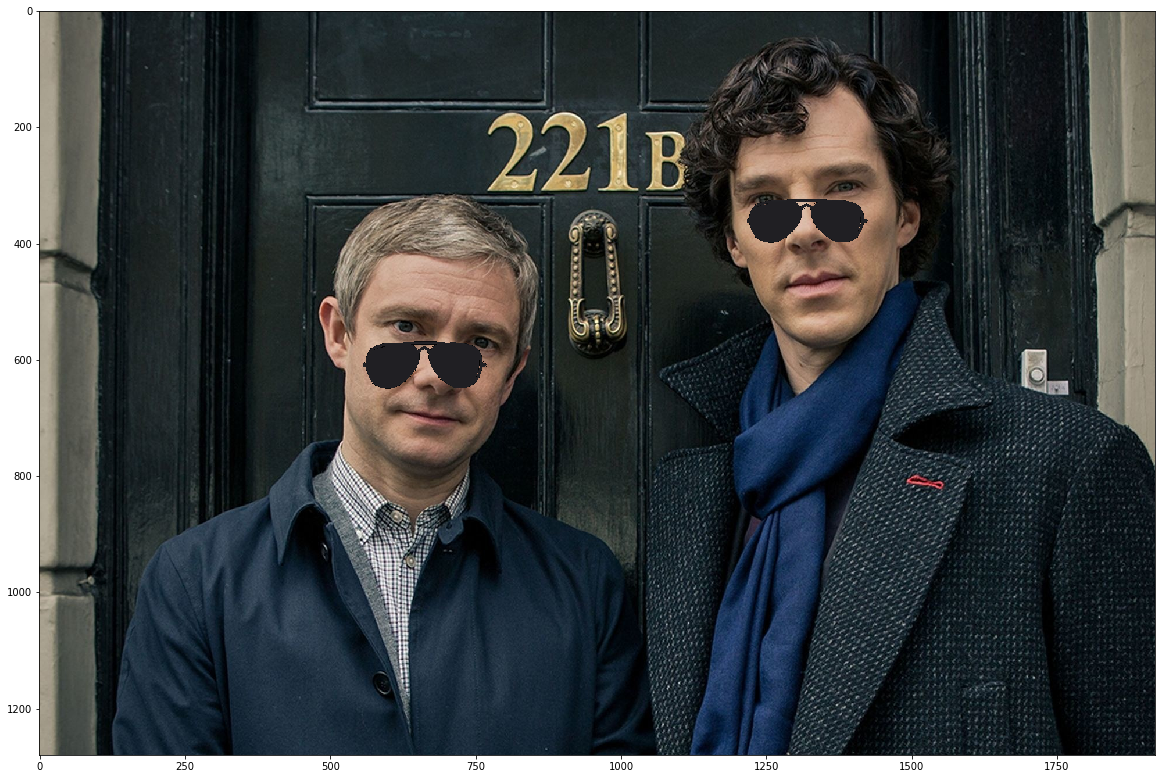

In [14]:
image_copy = np.copy(image)

# loop over the detected faces from your haar cascade
fig = plt.figure(figsize=(20,15))

for i, (x,y,w,h) in enumerate(face_vertices):
    
    # Select the region of interest that is the face in the image
    pad = 50
    roi = image_copy[y-pad:y+h+pad, x-pad:x+w+pad]
    
    ## TODO: Convert the face region from RGB to grayscale
    roi = cv2.cvtColor(roi, cv2.COLOR_RGB2GRAY)

    ## TODO: Normalize the grayscale image so that its color range falls in [0,1] instead of [0,255]
    roi = roi/255.0
    
    ## TODO: Rescale the detected face to be the expected square size for your CNN (224x224, suggested)
    if h > w:
        new_h, new_w = 224* h / w, 224
    elif w > h:
        new_h, new_w = 224, 224* w / h
    else:
        new_h, new_w = 224, 224
    new_h, new_w = int(new_h), int(new_w)

    roi = cv2.resize(roi, (new_w, new_h))
    
    ## TODO: Reshape the numpy image shape (H x W x C) into a torch image shape (C x H x W)
    # if image has no grayscale color channel, add one
    if(len(roi.shape) == 2):
        # add that third color dim
        roi_torch = roi.reshape(roi.shape[0], roi.shape[1], 1, 1)
        
    roi_torch = roi_torch.transpose((3, 2, 0, 1))
    roi_torch = torch.from_numpy(roi_torch)
    
    # convert images to FloatTensors
    roi_torch = roi_torch.type(torch.FloatTensor)
    #print(roi.size())
    
    roi_torch = roi_torch.to("cuda")
    
    net.to("cuda")
    
    ## TODO: Make facial keypoint predictions using your loaded, trained network
    output_pts = net(roi_torch)
    
    output_pts=output_pts.to("cpu")
    
    predicted_key_pts = output_pts.data
    predicted_key_pts = predicted_key_pts.numpy()
    
    #reshape to 68 x 2 pts
    predicted_key_pts = predicted_key_pts[0].reshape((68, 2))
    
    #undo normalization
    predicted_key_pts = predicted_key_pts*50.0+100
    
    #correct for scaling and padding to original image format
    predicted_key_pts[:, 0] = predicted_key_pts[:, 0]*(w+2*pad)/new_w + x-pad
    predicted_key_pts[:, 1] = predicted_key_pts[:, 1]*(h+2*pad)/new_h + y-pad
    
    shades_x = int(predicted_key_pts[17, 0])
    shades_y = int(predicted_key_pts[17, 1])
    shades_h = int(abs(predicted_key_pts[27,1] - predicted_key_pts[34,1]))
    shades_w = int(abs(predicted_key_pts[17,0] - predicted_key_pts[26,0]))
    
    new_shades = cv2.resize(shades, (shades_w, shades_h), interpolation = cv2.INTER_CUBIC)

   # get region of interest on the face to change
    roi_color = image[shades_y:shades_y+shades_h,shades_x:shades_x+shades_w]
    
    ind = np.argwhere(new_shades[:,:,3] > 0)
    
    for i in range(3):
        roi_color[ind[:,0],ind[:,1],i] = new_shades[ind[:,0],ind[:,1],i]
    
    image[shades_y:shades_y+shades_h,shades_x:shades_x+shades_w] = roi_color

    ## TODO: Display each detected face and the corresponding keypoints        
    #plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    #plt.axis('off')

plt.imshow(image)